## 3. ML Modeling

- In this notebook, we will illustrate how to train an XGBoost model with the diamonds dataset using the Snowpark ML Model API. 
- We also show how to do inference and deploy the model via Model Registry or as a UDF (See Appendix).

The Snowpark ML Model API currently supports sklearn, xgboost, and lightgbm models.

### Import Libraries

In [1]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.functions import udf
import snowflake.snowpark.functions as F

# Snowpark ML
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.registry import model_registry
from snowflake.ml._internal.utils import identifier

# data science libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

# misc
import json
import joblib
import cachetools

# warning suppresion
import warnings; warnings.simplefilter('ignore')

### Establish a Secure Connection to Snowflake

*Other connection options include Username/Password, MFA, OAuth, Okta, SSO. For more information, refer to the [Python Connector](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-example) documentation.*

In [2]:
# Make a Snowpark Connection

################################################################################################################
#  You can also use the SnowSQL Client to configure your connection params:
#  https://docs.snowflake.com/en/user-guide/snowsql-install-config.html
#
#  >>> from snowflake.ml.utils import connection_params
#  >>> session = Session.builder.configs(connection_params.SnowflakeLoginOptions()
#  >>> ).create()   
#
#  NOTE: If you have named connection params then specify the connection name
#  Example:
#  
#  >>> session = Session.builder.configs(
#  >>> connection_params.SnowflakeLoginOptions(connection_name='connections.snowml')
#  >>> ).create()
#
#################################################################################################################

# Edit the connection.json before creating the session object below
# Create Snowflake Session object
connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : SIKHADAS
Role                        : "ACCOUNTADMIN"
Database                    : "ML_HOL_DB"
Schema                      : "ML_HOL_SCHEMA"
Warehouse                   : "ML_HOL_WH"
Snowflake version           : 7.43.0
Snowpark for Python version : 1.9.0


In [3]:
# Specify the table name where we stored the diamonds dataset
# **nChange this only if you named your table something else in the data ingest notebook **
DEMO_TABLE = 'diamonds' 
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{DEMO_TABLE}"

### Load the data & preprocessing pipeline

In [4]:
# Load in the data
diamonds_df = session.table(input_tbl)
diamonds_df.show()

----------------------------------------------------------------------------------------------------
|"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |
----------------------------------------------------------------------------------------------------
|E        |SI2        |326      |IDEAL      |0.23     |3.95  |3.98  |2.43  |61.5     |55.0         |
|E        |SI1        |326      |PREMIUM    |0.21     |3.89  |3.84  |2.31  |59.8     |61.0         |
|E        |VS1        |327      |GOOD       |0.23     |4.05  |4.07  |2.31  |56.9     |65.0         |
|I        |VS2        |334      |PREMIUM    |0.29     |4.2   |4.23  |2.63  |62.4     |58.0         |
|J        |SI2        |335      |GOOD       |0.31     |4.34  |4.35  |2.75  |63.3     |58.0         |
|J        |VVS2       |336      |VERY_GOOD  |0.24     |3.94  |3.96  |2.48  |62.8     |57.0         |
|I        |VVS1       |336      |VERY_GOOD  |0.24     |3.95  |3.98  |2.47  |62.3     |57.0 

In [5]:
# Categorize all the features for modeling
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"] # To name the ordinal encoded columns
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

LABEL_COLUMNS = ['PRICE']
OUTPUT_COLUMNS = ['PREDICTED_PRICE']

In [6]:
# Load the preprocessing pipeline object (locally in this case but you can also load the one saved to stage in the previous notebook as an optional exercise)
PIPELINE_FILE = 'preprocessing_pipeline.joblib'
preprocessing_pipeline = joblib.load(PIPELINE_FILE)

### Build a simple XGBoost Regression model

What's happening here? 

- The `model.fit()` function actually creates a temporary stored procedure in the background. This also means that the model training is a single-node operation. Be sure to use a [Snowpark Optimized Warehouse](https://docs.snowflake.com/en/user-guide/warehouses-snowpark-optimized) if you need more memory. We are just using an XS Standard Virtual Warehouse here, which we created at the beginning of this quickstart.
- The `model.predict()` function actualls creates a temporary vectorized UDF in the background, which means the input DataFrame is batched as Pandas DataFrames and inference is parallelized across the batches of data.

You can check the query history once you execute the following cell to check.

In [7]:
# Split the data into train and test sets
diamonds_train_df, diamonds_test_df = diamonds_df.random_split(weights=[0.9, 0.1], seed=0)

# Run the train and test sets through the Pipeline object we defined earlier
train_df = preprocessing_pipeline.fit(diamonds_train_df).transform(diamonds_train_df)
test_df = preprocessing_pipeline.transform(diamonds_test_df)

In [8]:
# Define the XGBRegressor
regressor = XGBRegressor(
    input_cols=CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
regressor.fit(train_df)

# Predict
result = regressor.predict(test_df)

In [9]:
# Just to illustrate, we can also pass in a Pandas DataFrame to Snowpark ML's model.predict()
regressor.predict(test_df[CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS].to_pandas())

,CUT_OE,COLOR_OE,CLARITY_OE,CARAT,DEPTH,TABLE_PCT,X,Y,Z,PREDICTED_PRICE
0,2.0,6.0,5.0,0.020790,0.547222,0.307692,0.391993,0.072496,0.083648,322.593506
1,2.0,6.0,5.0,0.022869,0.455556,0.365385,0.408752,0.075212,0.082390,267.302460
2,1.0,5.0,3.0,0.008316,0.541667,0.269231,0.369646,0.066893,0.077673,385.477814
3,2.0,0.0,4.0,0.006237,0.486111,0.346154,0.368715,0.067402,0.075472,434.468170
4,1.0,4.0,5.0,0.020790,0.552778,0.307692,0.398510,0.071986,0.084277,566.351562
...,...,...,...,...,...,...,...,...,...,...
5407,2.0,1.0,5.0,0.103950,0.505556,0.269231,0.528864,0.097284,0.109748,2636.223389
5408,1.0,5.0,3.0,0.116424,0.452778,0.365385,0.552142,0.099321,0.109748,2343.046143
5409,2.0,1.0,4.0,0.103950,0.550000,0.326923,0.520484,0.095925,0.111006,2690.643066
5410,0.0,3.0,3.0,0.106029,0.511111,0.250000,0.536313,0.097284,0.111006,3194.863525


Let's analyze the results using Snowpark ML's MAPE.

In [10]:
mape = mean_absolute_percentage_error(df=result, 
                                        y_true_col_names="PRICE", 
                                        y_pred_col_names="PREDICTED_PRICE")

result.select("PRICE", "PREDICTED_PRICE").show()
print(f"Mean absolute percentage error: {mape}")

-------------------------------
|"PRICE"  |"PREDICTED_PRICE"  |
-------------------------------
|351      |322.593505859375   |
|353      |267.3024597167969  |
|355      |385.4778137207031  |
|357      |434.4681701660156  |
|554      |566.3515625        |
|554      |492.4712219238281  |
|2757     |2734.483642578125  |
|2759     |2950.267578125     |
|2759     |2802.850830078125  |
|2762     |2944.725341796875  |
-------------------------------

Mean absolute percentage error: 0.07117102331735715


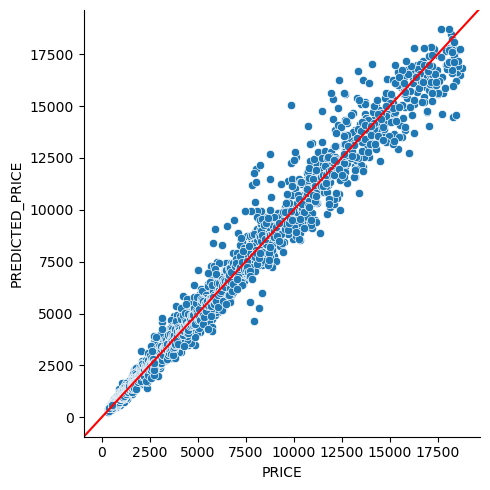

In [11]:
# Plot actual vs predicted 
g = sns.relplot(data=result["PRICE", "PREDICTED_PRICE"].to_pandas().astype("float64"), x="PRICE", y="PREDICTED_PRICE", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

### Now, let's use Snowpark ML's **Distributed** `GridSearchCV()` function to find optimal model parameters

We will increase the warehouse size to scale up our hyperparameter tuning to take advantage of parallelized model training to accelerate this search.

In [12]:
session.sql("ALTER WAREHOUSE ML_HOL_WH SET WAREHOUSE_SIZE=LARGE;").collect()

[Row(status='Statement executed successfully.')]

In [13]:
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[100, 200, 300, 400, 500],
        "learning_rate":[0.1, 0.2, 0.3, 0.4, 0.5],
    },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
grid_search.fit(train_df)

Package 'fastparquet' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


In [14]:
session.sql("ALTER WAREHOUSE ML_HOL_WH SET WAREHOUSE_SIZE=XSMALL;").collect()

[Row(status='Statement executed successfully.')]

We see that the best estimator has the following parameters: `n_estimators=500` & `learning_rate=0.4`.

We can use `to_sklearn()` in order to get the actual xgboost model object, which gives us access to all its attributes.

In [15]:
grid_search.to_sklearn().best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=3, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

We can also analyze the grid search results.

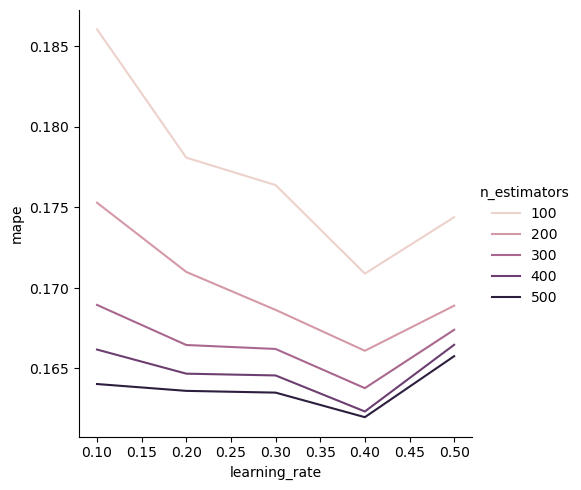

In [16]:
# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="learning_rate", y="mape", hue="n_estimators", kind="line")

plt.show()

This is consistent with the `learning_rate=0.4` and `n_estimator=500` chosen as the best estimator with the lowest MAPE.

Now, let's predict and analyze the results from using the best estimator.

In [17]:
# Predict
result = grid_search.predict(test_df)

# Analyze results
mape = mean_absolute_percentage_error(df=result, 
                                        y_true_col_names="PRICE", 
                                        y_pred_col_names="PREDICTED_PRICE")

result.select("PRICE", "PREDICTED_PRICE").show()
print(f"Mean absolute percentage error: {mape}")

--------------------------------
|"PRICE"  |"PREDICTED_PRICE"   |
--------------------------------
|351      |353.2740173339844   |
|353      |343.84271240234375  |
|355      |431.1207275390625   |
|357      |355.054443359375    |
|554      |560.3695068359375   |
|554      |527.7815551757812   |
|2757     |2796.111083984375   |
|2759     |2878.782958984375   |
|2759     |3021.80224609375    |
|2762     |2838.24658203125    |
--------------------------------

Mean absolute percentage error: 0.06614988993792766


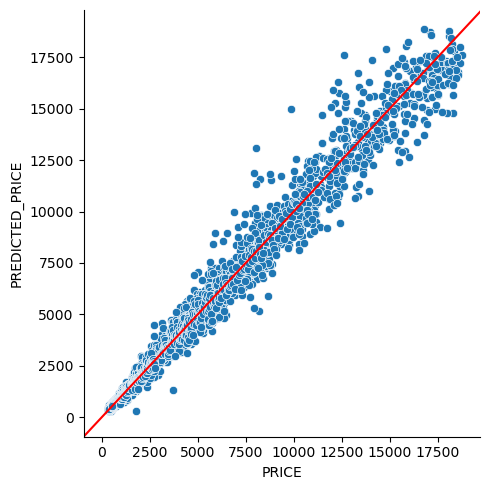

In [18]:
# Plot actual vs predicted 
g = sns.relplot(data=result["PRICE", "PREDICTED_PRICE"].to_pandas().astype("float64"), x="PRICE", y="PREDICTED_PRICE", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

### Model deployment using Model Registry

Now, with Snowpark ML's model registry, we have a Snowflake native model versioning and deployment framework. This allows us to log models, tag parameters and metrics, track metadata, create versions, and ultimately deploy models into a Snowflake warehouse or Snowpark Container Service for batch scoring tasks.

In [19]:
# Let's save our optimal model first and its metadata
optimal_model = grid_search.to_sklearn().best_estimator_
optimal_n_estimators = grid_search.to_sklearn().best_estimator_.n_estimators
optimal_learning_rate = grid_search.to_sklearn().best_estimator_.learning_rate

optimal_mape = gs_results_df.loc[(gs_results_df['n_estimators']==optimal_n_estimators) &
                                 (gs_results_df['learning_rate']==optimal_learning_rate), 'mape'].values[0]

First, we will log our model.

In [20]:
# Get sample input data to pass into the registry logging function
X = train_df.select(CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS).limit(100)

db = identifier._get_unescaped_name(session.get_current_database())
schema = identifier._get_unescaped_name(session.get_current_schema())

# Define model name and version
model_name = "diamonds_model"
model_version = 1

# Create a registry and log the model
registry = model_registry.ModelRegistry(session=session, database_name=db, schema_name=schema, create_if_not_exists=True)

registry.log_model(
    model_name=model_name,
    model_version=model_version,
    model=optimal_model,
    sample_input_data=X,
    options={"embed_local_ml_library": True, # This option is enabled to pull latest dev code changes.
             "relax": True} # relax dependencies
)

# Add evaluation metric
registry.set_metric(model_name=model_name, model_version=model_version, metric_name="mean_abs_pct_err", metric_value=optimal_mape)

create_model_registry() is in private preview since 0.2.0. Do not use it in production. 


In [21]:
# Let's confirm it was added
registry.list_models().to_pandas()

,CREATION_CONTEXT,CREATION_ENVIRONMENT_SPEC,CREATION_ROLE,CREATION_TIME,ID,INPUT_SPEC,NAME,OUTPUT_SPEC,RUNTIME_ENVIRONMENT_SPEC,TYPE,URI,VERSION,ARTIFACT_IDS,DESCRIPTION,METRICS,TAGS,REGISTRATION_TIMESTAMP
0,None,"{\n ""python"": ""3.9.18""\n}","""ACCOUNTADMIN""",2023-12-05 14:11:08.668000-08:00,2913cbf493bb11ee9e169e6c7f2f9bc3,None,diamonds_model,None,None,xgboost,sfc://ML_HOL_DB.ML_HOL_SCHEMA.SNOWML_MODEL_291...,1,None,None,"{\n ""mean_abs_pct_err"": 0.16197244497750451\n}",None,2023-12-05 14:11:09.928000-08:00


Now, we're ready to deploy to a Snowflake Warehouse.

In [22]:
# Pick a deployment name and deploy
model_deployment_name = model_name + f"{model_version}" + "_UDF"

registry.deploy(model_name=model_name,
                model_version=model_version,
                deployment_name=model_deployment_name, 
                target_method="predict", 
                permanent=True, 
                options={"relax_version": True})

{'name': 'ML_HOL_DB.ML_HOL_SCHEMA.diamonds_model1_UDF',
 'platform': <TargetPlatform.WAREHOUSE: 'warehouse'>,
 'target_method': 'predict',
 'signature': ModelSignature(
                     inputs=[
                         FeatureSpec(dtype=DataType.DOUBLE, name='CUT_OE'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='COLOR_OE'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='CLARITY_OE'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='CARAT'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='DEPTH'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='TABLE_PCT'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='X'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='Y'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='Z')
                     ],
                     outputs=[
                         FeatureSpec(dtype=DataType.FLOAT, name='output_feature_0')
                     ]
                 ),
 'options': {'relax_version': True,
  'permanent_udf_stage_location': '@ML_HOL_DB.ML_HOL_SCHEMA._SYSTEM_REGISTRY_DEPLOYM

In [23]:
# Let's confirm it was added
registry.list_deployments(model_name, model_version).to_pandas()

,MODEL_NAME,MODEL_VERSION,DEPLOYMENT_NAME,CREATION_TIME,TARGET_METHOD,TARGET_PLATFORM,SIGNATURE,OPTIONS,STAGE_PATH,ROLE
0,diamonds_model,1,diamonds_model1_UDF,2023-12-05 14:11:50.384000-08:00,predict,warehouse,"{\n ""inputs"": [\n {\n ""name"": ""CUT_OE...","{\n ""permanent_udf_stage_location"": ""@ML_HOL_...",@ML_HOL_DB.ML_HOL_SCHEMA._SYSTEM_REGISTRY_DEPL...,"""ACCOUNTADMIN"""


Now we can use the deployed model to perform inference.

In [24]:
# We can always get a reference to our registry using this function call
model_ref = model_registry.ModelReference(registry=registry, model_name=model_name, model_version=model_version)

# We can then use the deployed model to perform inference
result_sdf = model_ref.predict(deployment_name=model_deployment_name, data=test_df)
#result_sdf.rename(F.col('"output_feature_0"'),"PREDICTED_PRICE").show()
result_sdf.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"output_feature_0"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.02079002079002079   |0.5472222222222223   |0.3076923076923076   |0.3919925512104283   |0.07249575551782682  |0.08364779874213837  |2.0       |6.0         |5.0           |J        |SI1        |351      |VERY_GOOD  |353.2740173339844   |
|0.02286902286902287   |0.4555555555555555  

Let's do some clean up now.

In [25]:
# Clean up
registry.delete_deployment(model_name=model_name, model_version=model_version, deployment_name=model_deployment_name)
registry.delete_model(model_name=model_name, model_version=model_version, delete_artifact=True)

In [26]:
registry.list_deployments(model_name, model_version).to_pandas()

,MODEL_NAME,MODEL_VERSION,DEPLOYMENT_NAME,CREATION_TIME,TARGET_METHOD,TARGET_PLATFORM,SIGNATURE,OPTIONS,STAGE_PATH,ROLE


In [27]:
registry.list_models().to_pandas()

,CREATION_CONTEXT,CREATION_ENVIRONMENT_SPEC,CREATION_ROLE,CREATION_TIME,ID,INPUT_SPEC,NAME,OUTPUT_SPEC,RUNTIME_ENVIRONMENT_SPEC,TYPE,URI,VERSION,ARTIFACT_IDS,DESCRIPTION,METRICS,TAGS,REGISTRATION_TIMESTAMP


### Appendix

#### Deploy model using a Vectorized UDF

In case you need to deploy a model not trained using Snowpark ML or externally trained, you can still deploy via Vectorized UDFs.

In [28]:
# Let's save our optimal model first
MODEL_FILE = 'model.joblib'
joblib.dump(optimal_model, MODEL_FILE) # we are just pickling it locally first

# You can also save the pickled object into the stage we created earlier
session.file.put(MODEL_FILE, "@ML_HOL_ASSETS", overwrite=True)

# Get all relevant column names to pass into the UDF call
feature_cols = test_df[CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS].columns

In [29]:
# Cache the model load to optimize inference
@cachetools.cached(cache={})
def load_model(filename):
    import joblib
    import sys
    import os

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Register the UDF via decorator
@udf(name='batch_predict_diamond', 
     session=session, 
     replace=True, 
     is_permanent=True, 
     stage_location='@ML_HOL_ASSETS',
     input_types=[F.FloatType()]*len(feature_cols),
     return_type=F.FloatType(),
     imports=['@ML_HOL_ASSETS/model.joblib.gz'],
     packages=['pandas','joblib','cachetools','xgboost'])
def batch_predict_diamond(test_df: pd.DataFrame) -> pd.Series:
    # Need to name the columns because column names aren't passed in to this function
    test_df.columns = ["CUT_OE", "COLOR_OE", "CLARITY_OE", 'CARAT', 'DEPTH', 'TABLE_PCT', 'X', 'Y', 'Z']
    model = load_model('model.joblib.gz')
    return model.predict(test_df) # This is using the XGBoost library's model.predict(), not Snowpark ML's

Call Vectorized User-Defined Function (UDF) on test data.

In [30]:
test_df_w_preds = test_df.with_column('PREDICTED_PRICE', batch_predict_diamond(*feature_cols))
test_df_w_preds.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"PREDICTED_PRICE"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.02079002079002079   |0.5472222222222223   |0.3076923076923076   |0.3919925512104283   |0.07249575551782682  |0.08364779874213837  |2.0       |6.0         |5.0           |J        |SI1        |351      |VERY_GOOD  |353.2740173339844   |
|0.02286902286902287   |0.4555555555555555  

In [31]:
session.close()